In [74]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [75]:
# set paths and create dirs
data_dir = 'data'
helper_dir = 'helper'
output_dir = 'output'
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [79]:
# load helper functions
%run {helper_dir}/mk_design_matrix.py
%run {helper_dir}/plot.py
%run {helper_dir}/fit_data.py

## Prep Data

In [4]:
chain = 'Avalanche' # Arbitrum

In [5]:
fnames = {'fees': 'Fees_2022-01-06_2022-06-26.csv',
          'volume': 'Volume_2022-01-06_2022-06-26.csv',
         }

In [6]:
# read daily data
lst_of_dfs = []
for key, fname in fnames.items():
    # only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
    # which we don't want.
    df = pd.read_csv(os.path.join(data_dir, chain, fname), parse_dates=['Date'], index_col='Date', usecols=range(6))
    df.columns = df.columns.str.lower().str.replace(' ', '_') + '_{}'.format(key)
    # calc daily total 
    df['total_{}'.format(key)] = df.sum(axis=1)
    lst_of_dfs.append(df)
df = pd.concat(lst_of_dfs, axis=1)    
df.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172 entries, 2022-01-06 to 2022-06-26
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   swap_fees              172 non-null    float64
 1   margin_trading_fees    172 non-null    float64
 2   mint_glp_fees          172 non-null    float64
 3   burn_glp_fees          172 non-null    float64
 4   liquidation_fees       172 non-null    float64
 5   total_fees             172 non-null    float64
 6   swap_volume            172 non-null    float64
 7   margin_trading_volume  172 non-null    float64
 8   mint_glp_volume        172 non-null    float64
 9   burn_glp_volume        172 non-null    float64
 10  liquidation_volume     172 non-null    float64
 11  total_volume           172 non-null    float64
dtypes: float64(12)
memory usage: 17.5 KB


In [7]:
# drop the last row because the most recent date may not be a full day
df = df.iloc[:-1, :]
df.info()


# drop the first row because it's the day when the platform opened shop

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171 entries, 2022-01-06 to 2022-06-25
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   swap_fees              171 non-null    float64
 1   margin_trading_fees    171 non-null    float64
 2   mint_glp_fees          171 non-null    float64
 3   burn_glp_fees          171 non-null    float64
 4   liquidation_fees       171 non-null    float64
 5   total_fees             171 non-null    float64
 6   swap_volume            171 non-null    float64
 7   margin_trading_volume  171 non-null    float64
 8   mint_glp_volume        171 non-null    float64
 9   burn_glp_volume        171 non-null    float64
 10  liquidation_volume     171 non-null    float64
 11  total_volume           171 non-null    float64
dtypes: float64(12)
memory usage: 17.4 KB


In [8]:
# make linear trend features
X = mk_X_linear_trend(df.index)
X.head()

,trend
Date,
2022-01-06,1.0000
2022-01-07,2.0000
2022-01-08,3.0000
2022-01-09,4.0000
2022-01-10,5.0000


In [9]:
# roll up to weekly level
df_weekly = df.groupby(df.index.isocalendar().week).sum()

# make linear trend features for weekly level
X_weekly = df_weekly.index.values.reshape(-1,1)
X_weekly.shape

(25, 1)

## Fees per $1M Volume

In [10]:
fees_per_milvolume = df.total_fees/df.total_volume * 1e6
fees_per_milvolume.sort_values(ascending=False).head(5)

Date
2022-06-07   9,129.9715
2022-04-24   4,645.5718
2022-01-06   3,189.7345
2022-05-12   2,500.4721
2022-03-24   2,256.6381
dtype: float64

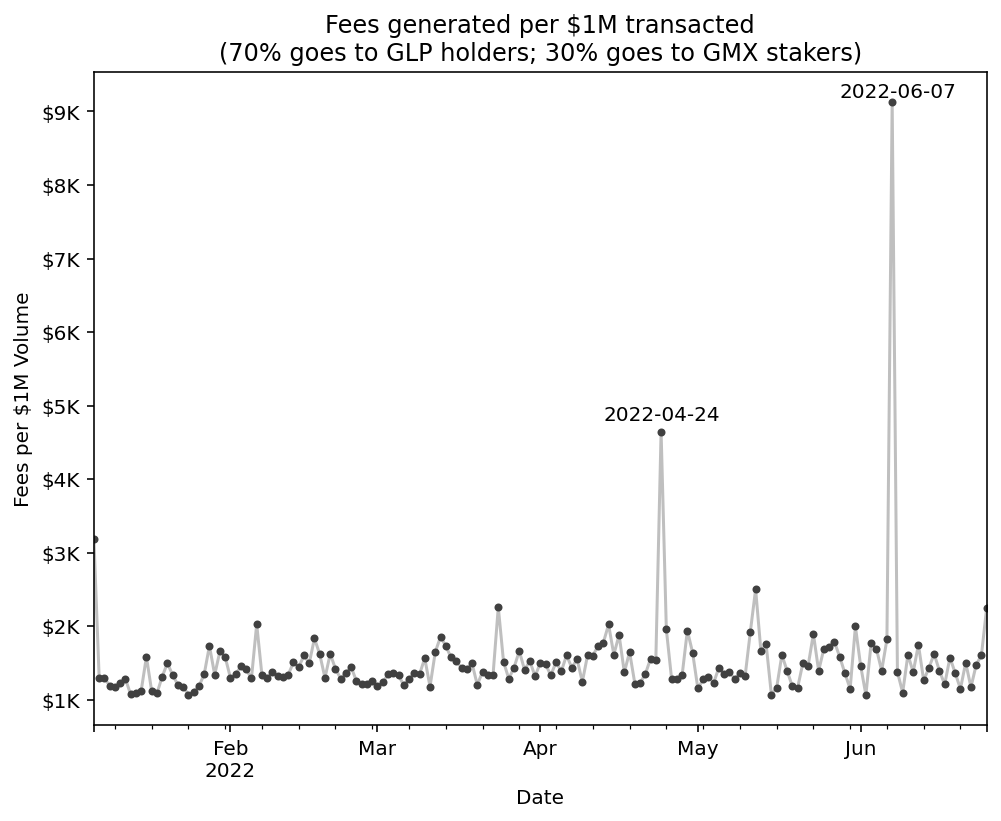

In [11]:
ax = fees_per_milvolume.plot(
    **plot_params, 
    title="Fees generated per $1M transacted\n(70% goes to GLP holders; 30% goes to GMX stakers)",
    ylabel='Fees per $1M Volume')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-05-28', 9.2e3, '2022-06-07')
ax.text('2022-04-13', 4.8e3, '2022-04-24');

In [12]:
avg = np.mean(fees_per_milvolume)
ste = st.sem(fees_per_milvolume, ddof=0) # same as std / sqrt(n), do not use the default ddof=1
ci99 = st.norm.interval(alpha=.99, loc=avg, scale=ste)
print("For every $1M transacted, GXM generates an average cashflow of ${:.0f} with a 99% confidence interval of (${:.0f}, ${:.0f}).".format(avg, ci99[0], ci99[1]))
print("Of the ${:.0f} generated, ${:.0f} goes to GLP holders, and ${:.0f} goes to GMX stakers.".format(avg, avg*.7, avg*.3))

For every $1M transacted, GXM generates an average cashflow of $1516 with a 99% confidence interval of ($1380, $1653).
Of the $1516 generated, $1061 goes to GLP holders, and $455 goes to GMX stakers.


## Volume Growth

In [13]:
yvar = 'total_volume'

### Daily

In [14]:
y = df.loc[:, yvar]   # extract target
dd = fit_linreg(X, y) # fit linear trend line
yhat = dd['yhat']
slope = dd['slope']

intercept: 97328564.59930739 slope: -377577.77622182335


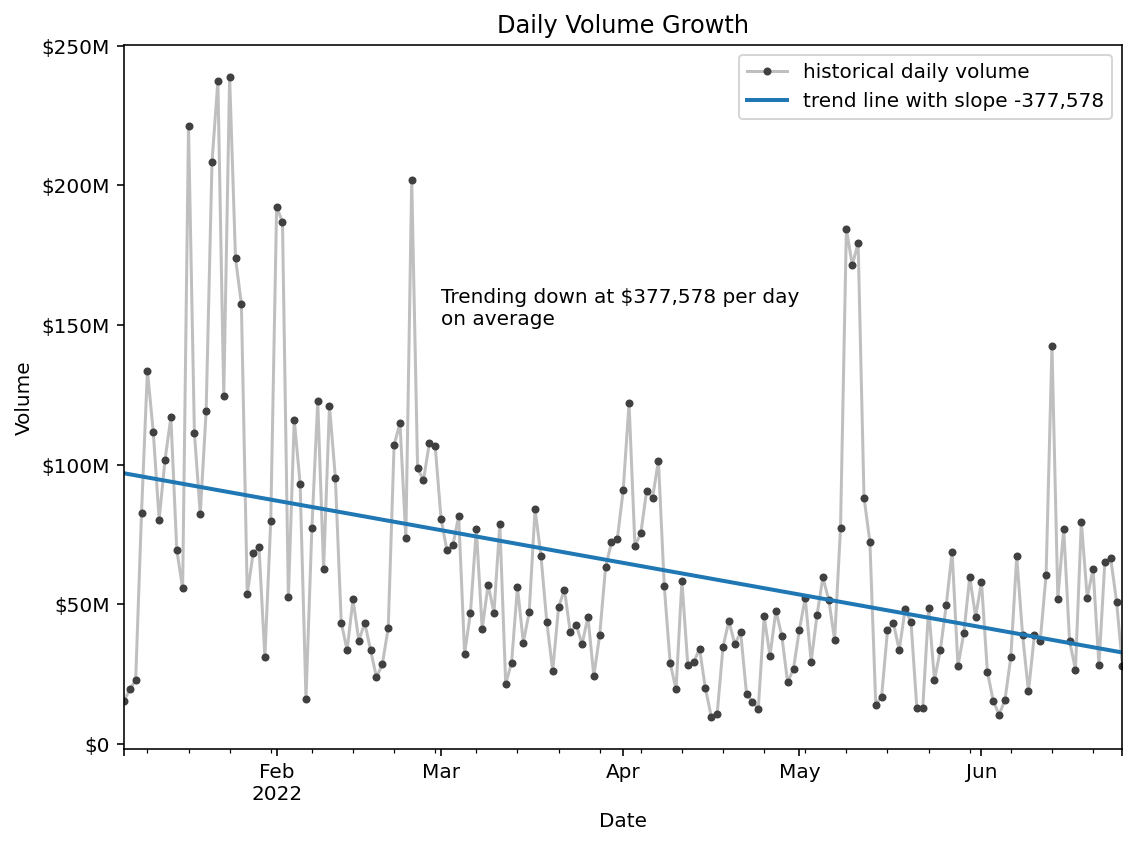

In [15]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Daily Volume Growth', ylabel='Volume', 
    ytru_legend='historical daily volume', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-03-01', 150e6, "Trending down at ${:,.0f} per day\non average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'daily_volume_growth_trend.png'), dpi=300);

### Weekly

In [16]:
y = df_weekly.loc[:, yvar]   # extract target
dd = fit_linreg(X_weekly, y) # fit linear trend line
yhat = dd['yhat']
slope = dd['slope']

intercept: 646419998.8010058 slope: -15599920.617420657


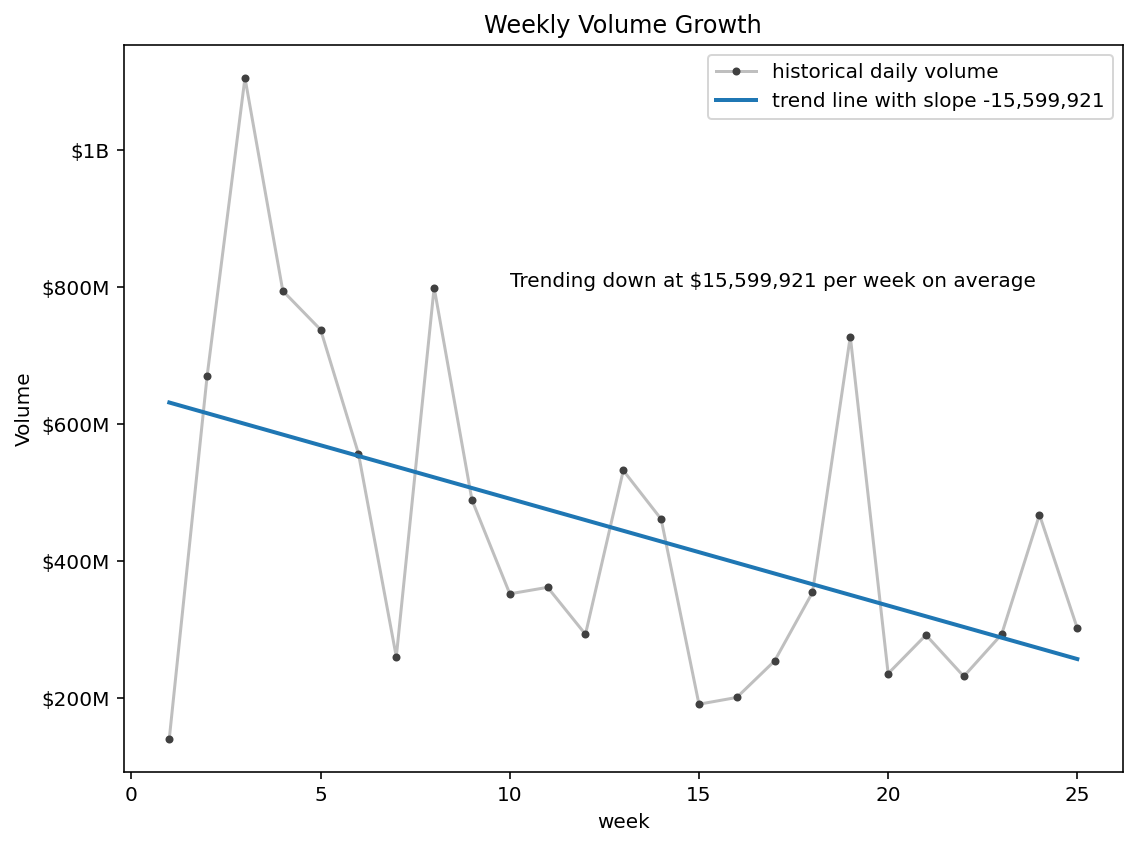

In [17]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Volume Growth', ylabel='Volume', 
    ytru_legend='historical daily volume', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
ax.text(10, 800e6, "Trending down at ${:,.0f} per week on average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'weekly_volume_growth_trend.png'), dpi=300);

## Fee Growth

In [18]:
yvar = 'total_fees'

### Daily

In [19]:
# extract target
y = df.loc[:, yvar]

# fit linear trend line
dd = fit_linreg(X, y) 
yhat = dd['yhat']
slope = dd['slope']

intercept: 120504.41797347405 slope: -314.57990223384115


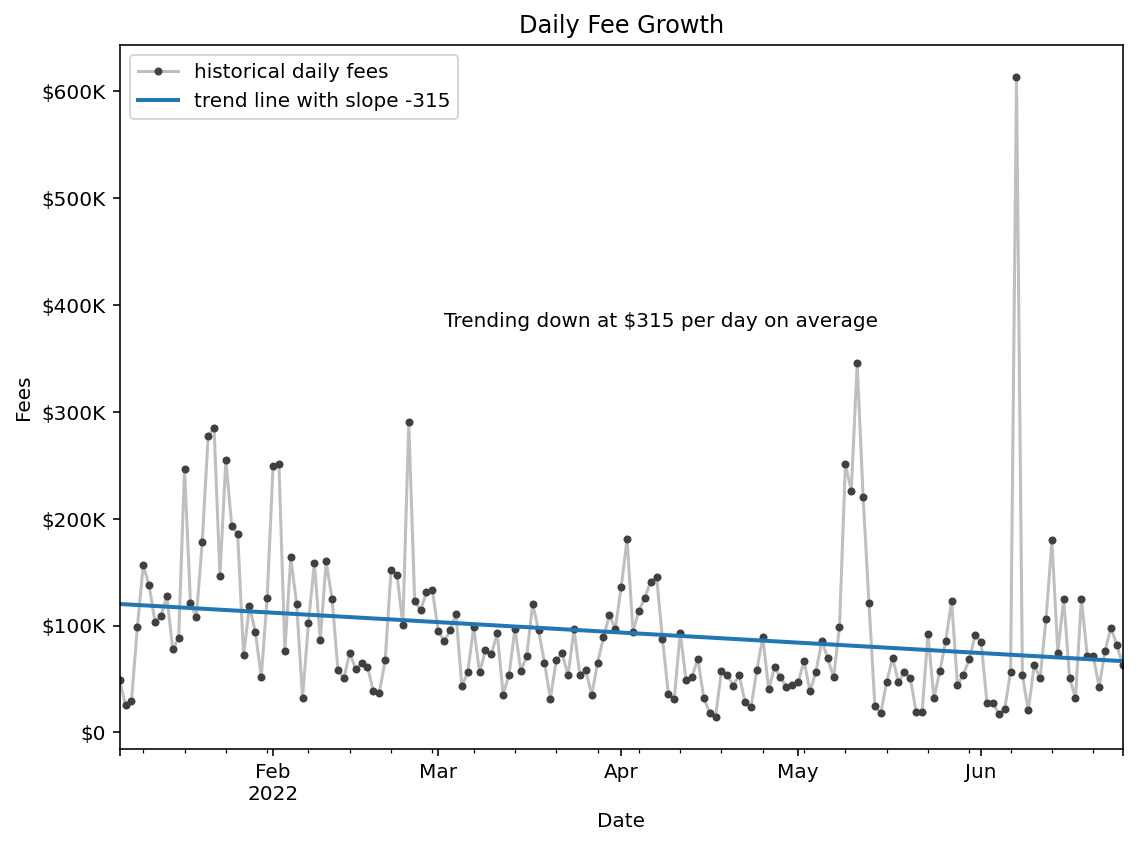

In [20]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Daily Fee Growth', ylabel='Fees', 
    ytru_legend='historical daily fees', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True))
ax.yaxis.set_major_formatter(formatter)
ax.text('2022-03-02', 380_000, "Trending down at ${:,.0f} per day on average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'daily_fee_growth_trend.png'), dpi=300);

### Weekly

In [21]:
# extract target
y = df_weekly.loc[:, yvar]

# fit linear trend line
dd = fit_linreg(X_weekly, y) 
yhat = dd['yhat']
slope = dd['slope']

intercept: 794482.8503651659 slope: -11944.701008972159


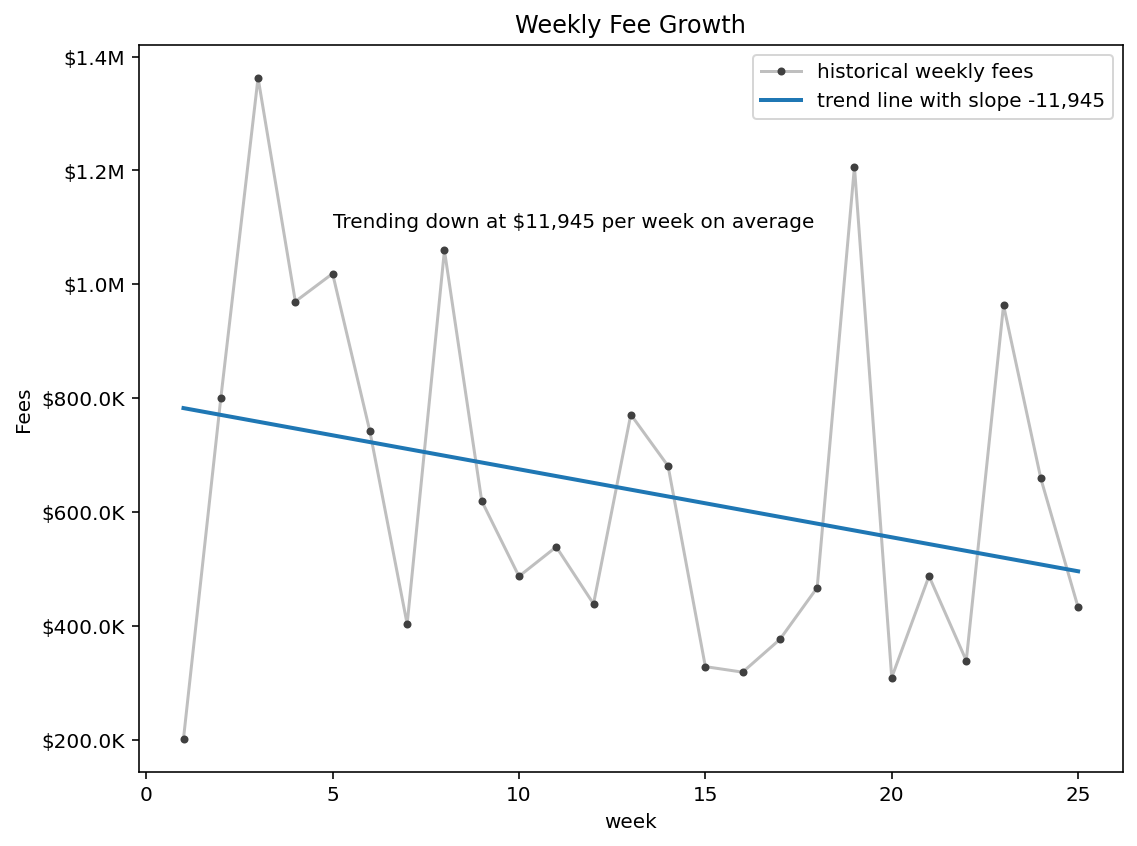

In [22]:
ax = plot_timeseries_with_trendline(
    y, yhat, title='Weekly Fee Growth', ylabel='Fees', 
    ytru_legend='historical weekly fees', yhat_legend="trend line with slope {:,.0f}".format(slope))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax.yaxis.set_major_formatter(formatter)
ax.text(5, 1.1e6, "Trending down at ${:,.0f} per week on average".format(abs(slope)))
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(png_dir, 'weekly_fee_growth_trend.png'), dpi=300);

## Who contributed the most fees? 

In [85]:
da = (df.loc[:, df.columns.str.contains('fees')]
      .groupby(df.index.isocalendar().week)
      .sum()
      .assign(trader_fees = lambda x: x.margin_trading_fees + x.liquidation_fees,
              glper_fees = lambda x: x.mint_glp_fees + x.burn_glp_fees,
              swap_fees_pct = lambda x: x.swap_fees / x.total_fees,
              trader_fees_pct = lambda x: x.trader_fees / x.total_fees,
              glper_fees_pct = lambda x: x.glper_fees / x.total_fees)
      .loc[:, ['trader_fees_pct', 'swap_fees_pct', 'glper_fees_pct']])
da.head(10)

,trader_fees_pct,swap_fees_pct,glper_fees_pct
week,,,
1,0.5173,0.1714,0.3114
2,0.8222,0.1083,0.0695
3,0.7892,0.1577,0.0531
4,0.8064,0.1182,0.0754
5,0.6937,0.2097,0.0967
6,0.6641,0.2152,0.1207
7,0.5128,0.2885,0.1986
8,0.6498,0.2621,0.0881
9,0.7080,0.2272,0.0648


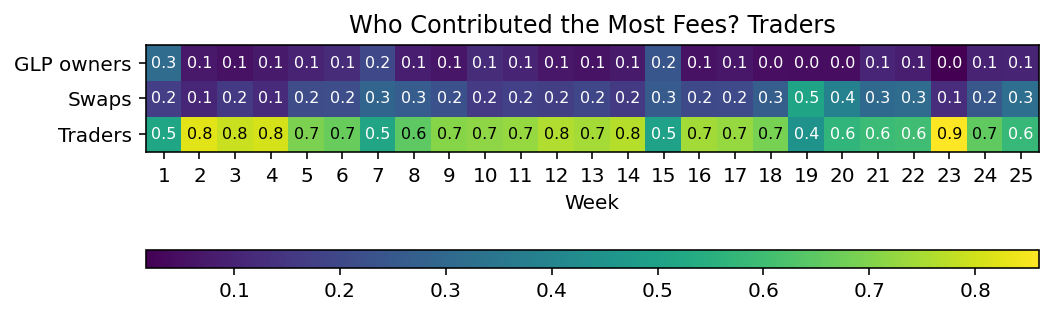

In [94]:
scores_image = heatmap(
    da.T, xlabel='Week', 
    ylabel='', xticklabels=da.index,
    yticklabels=da.columns.map({'trader_fees_pct':'Traders', 'swap_fees_pct':'Swaps', 'glper_fees_pct':'GLP owners'}),
    cmap=plt.cm.viridis, fmt='%.1f', text_size=8
)
plt.title("Who Contributed the Most Fees? Traders")
plt.colorbar(scores_image, location="bottom", aspect=50);